In [144]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [145]:
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid",
              palette="colorblind", color_codes=True,
              rc={"figure.figsize": [10, 6]})

Portfolio Optimization and Value at Risk (VaR) using Monte Carlo Simulation and Scipy Optimize 

In [147]:
import pandas as pd  
import numpy as np
import yfinance as yf
import datetime
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
plt.style.use('fivethirtyeight')

In [148]:
tickers = ['ADBE', 'AMD','AMZN','AAPL','GOOG','META','MSFT', 'NFLX','NVDA','TSLA']
start = datetime.datetime(2019,7, 14)
end = datetime.datetime(2023, 7, 14)
df = yf.download(tickers, start, end)['Adj Close']
df.columns = tickers

[*********************100%***********************]  10 of 10 completed


In [149]:
tickers.sort()

In [150]:
df.head().dropna()

ADBE         AMD       AMZN        AAPL       GOOG   
Date                                                                  
2019-07-15  49.774849  308.760010  34.389999  101.049500  57.516998  \
2019-07-16  49.602627  305.700012  33.849998  100.495003  57.679001   
2019-07-17  49.323696  309.390015  33.599998   99.601501  57.317501   
2019-07-18  49.883995  310.079987  33.000000   98.894997  57.316502   
2019-07-19  49.139351  306.869995  32.509998   98.225998  56.505001   

                  META        MSFT        NFLX       NVDA       TSLA  
Date                                                                  
2019-07-15  203.910004  133.504578  366.600006  41.589931  16.900000  
2019-07-16  203.839996  131.755295  365.989990  41.542694  16.825333  
2019-07-17  201.800003  130.976791  362.440002  42.196629  16.990667  
2019-07-18  200.779999  131.120895  325.209991  42.313477  16.902666  
2019-07-19  198.360001  131.313141  315.100006  41.880852  17.212000

In [151]:
df.tail().dropna()

ADBE         AMD        AMZN        AAPL        GOOG   
Date                                                                     
2023-07-07  190.679993  485.269989  113.169998  129.779999  120.139999  \
2023-07-10  188.610001  496.350006  113.580002  127.129997  116.870003   
2023-07-11  188.080002  504.739990  111.320000  128.779999  117.709999   
2023-07-12  189.770004  507.359985  114.580002  130.800003  119.620003   
2023-07-13  190.539993  517.280029  115.919998  134.300003  124.830002   

                  META        MSFT        NFLX        NVDA        TSLA  
Date                                                                    
2023-07-07  290.529999  337.220001  438.100006  425.029999  274.429993  
2023-07-10  294.100006  331.829987  441.709991  421.799988  269.609985  
2023-07-11  298.290009  332.470001  440.209991  424.049988  269.790009  
2023-07-12  309.339996  337.200012  444.049988  439.019989  271.989990  
2023-07-13  313.410004  342.660004  450.380005  459.769989  277.899994

In [152]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import pandas_bokeh
cf.go_offline()
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [153]:
df.iplot()

In [154]:
fig_price=px.line(df, title='Price of individual Stocks')
fig_price.show()

In [155]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
        
    return results_df

In [156]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.04
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

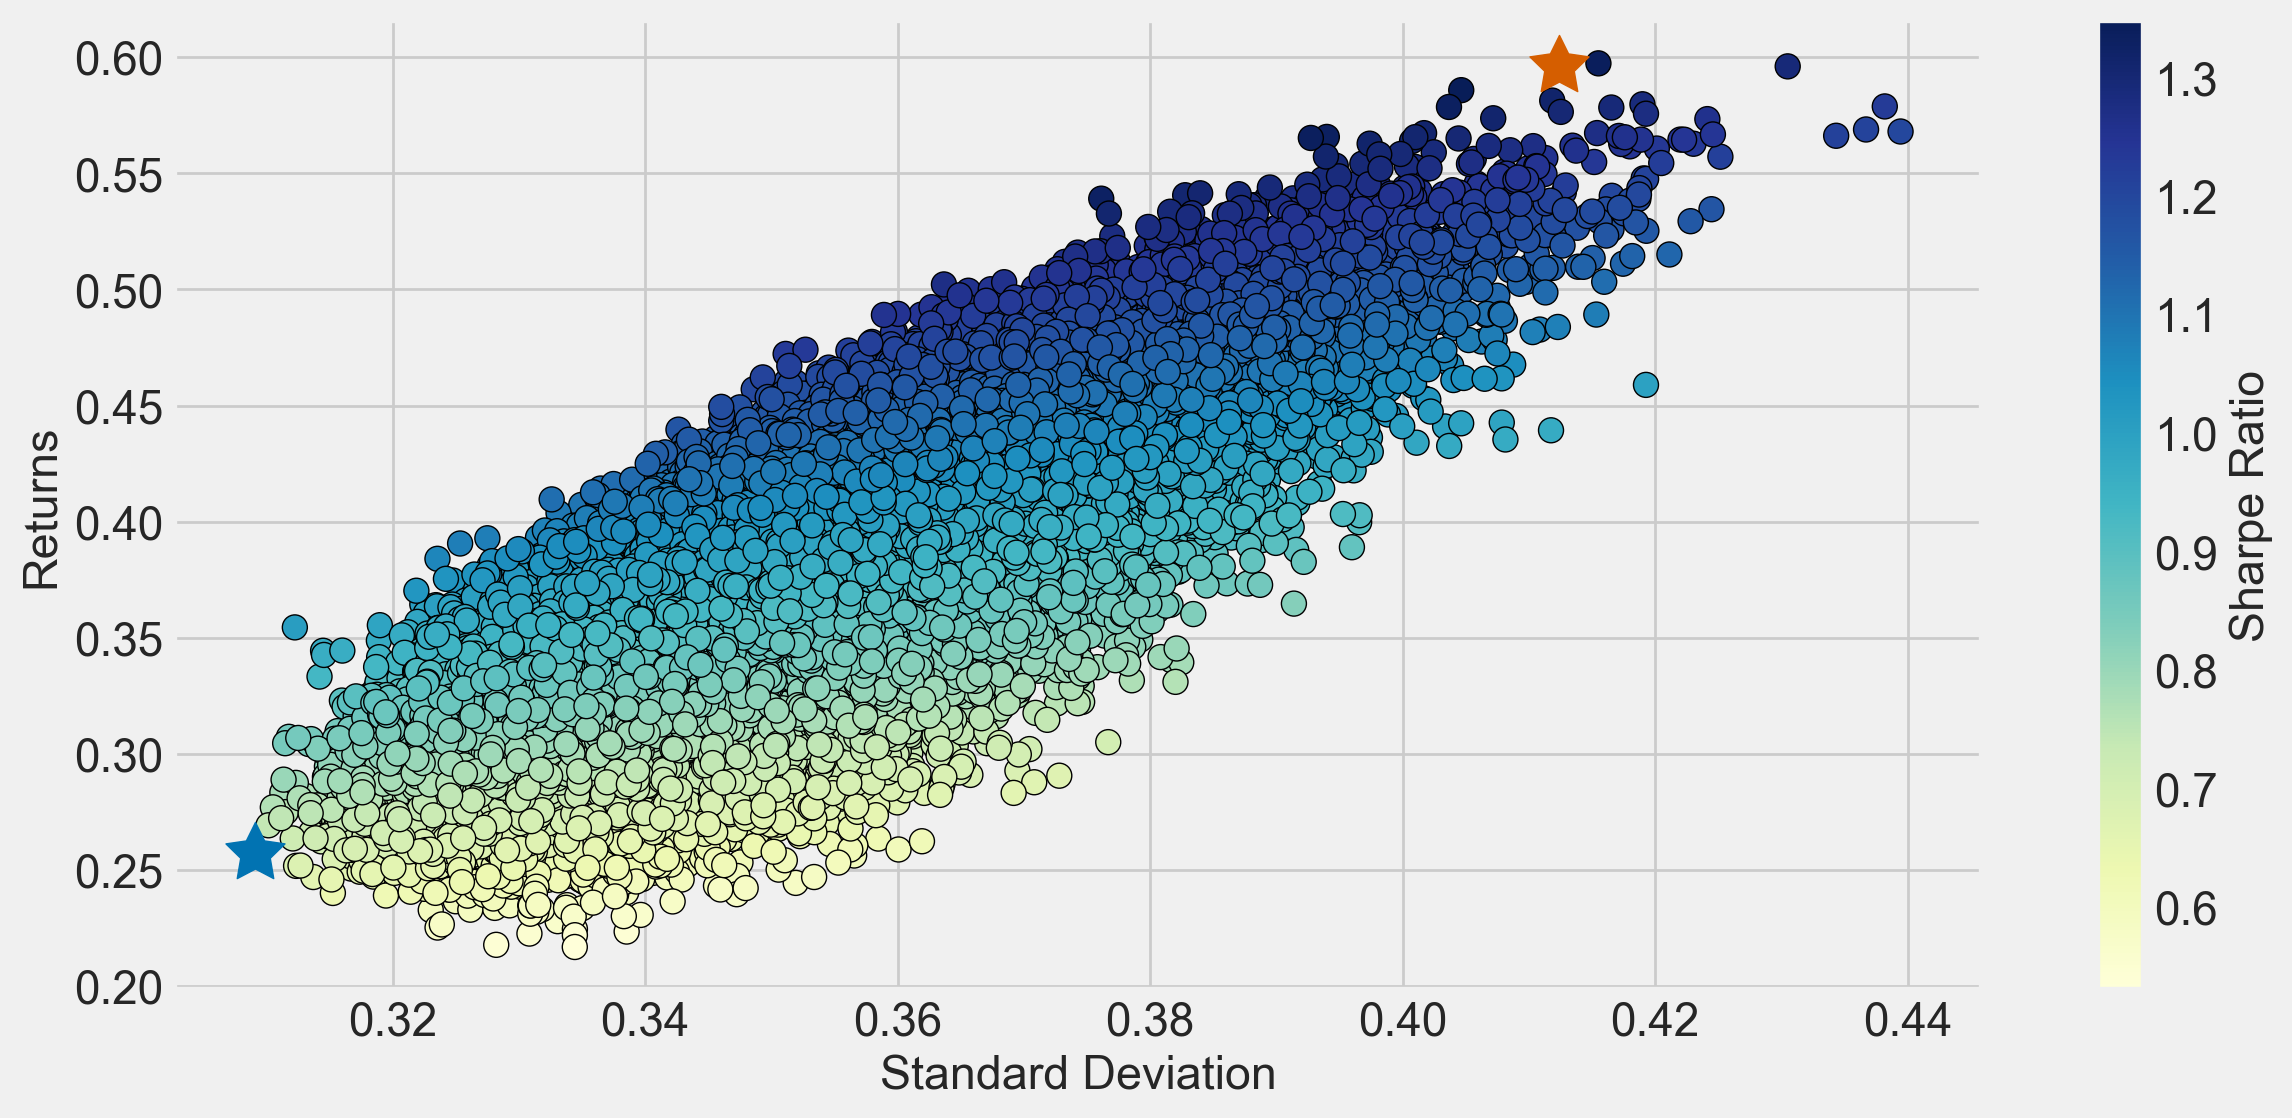

In [157]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(13,6))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe, edgecolors="black", cmap='YlGnBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe Ratio')
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)
#plot blue star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='b',s=500)
plt.show()

In [158]:
max_sharpe_port.to_frame().T

ret     stdev   sharpe      AAPL      ADBE       AMD      AMZN   
52655  0.596377  0.412412  1.34908  0.191707  0.006591  0.120344  0.045615  \

          GOOG      META      MSFT      NFLX      NVDA      TSLA  
52655  0.05591  0.018435  0.043085  0.008895  0.261922  0.247497

In [159]:
min_vol_port.to_frame().T

ret    stdev    sharpe      AAPL     ADBE       AMD      AMZN   
96988  0.257152  0.30914  0.702439  0.189427  0.15626  0.012186  0.187617  \

           GOOG      META      MSFT      NFLX      NVDA      TSLA  
96988  0.193299  0.030467  0.133513  0.082508  0.013138  0.001585

In [160]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)

In [161]:
pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']],index=tickers).T

AAPL  ADBE  AMD  AMZN  GOOG  META  MSFT  NFLX  NVDA  TSLA
0  0.06   0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.52  0.42

In [162]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std
def min_variance(mean_returns, cov):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
min_port_variance = min_variance(mean_returns, cov)

In [163]:
pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers).T

AAPL  ADBE  AMD  AMZN  GOOG  META  MSFT  NFLX  NVDA  TSLA
0  0.26   0.0  0.0  0.13  0.29   0.0  0.26  0.06   0.0   0.0

In [164]:
def calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var

def simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])
        
    return results_df

In [165]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.04
days = 252
alpha = 0.05
results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days)

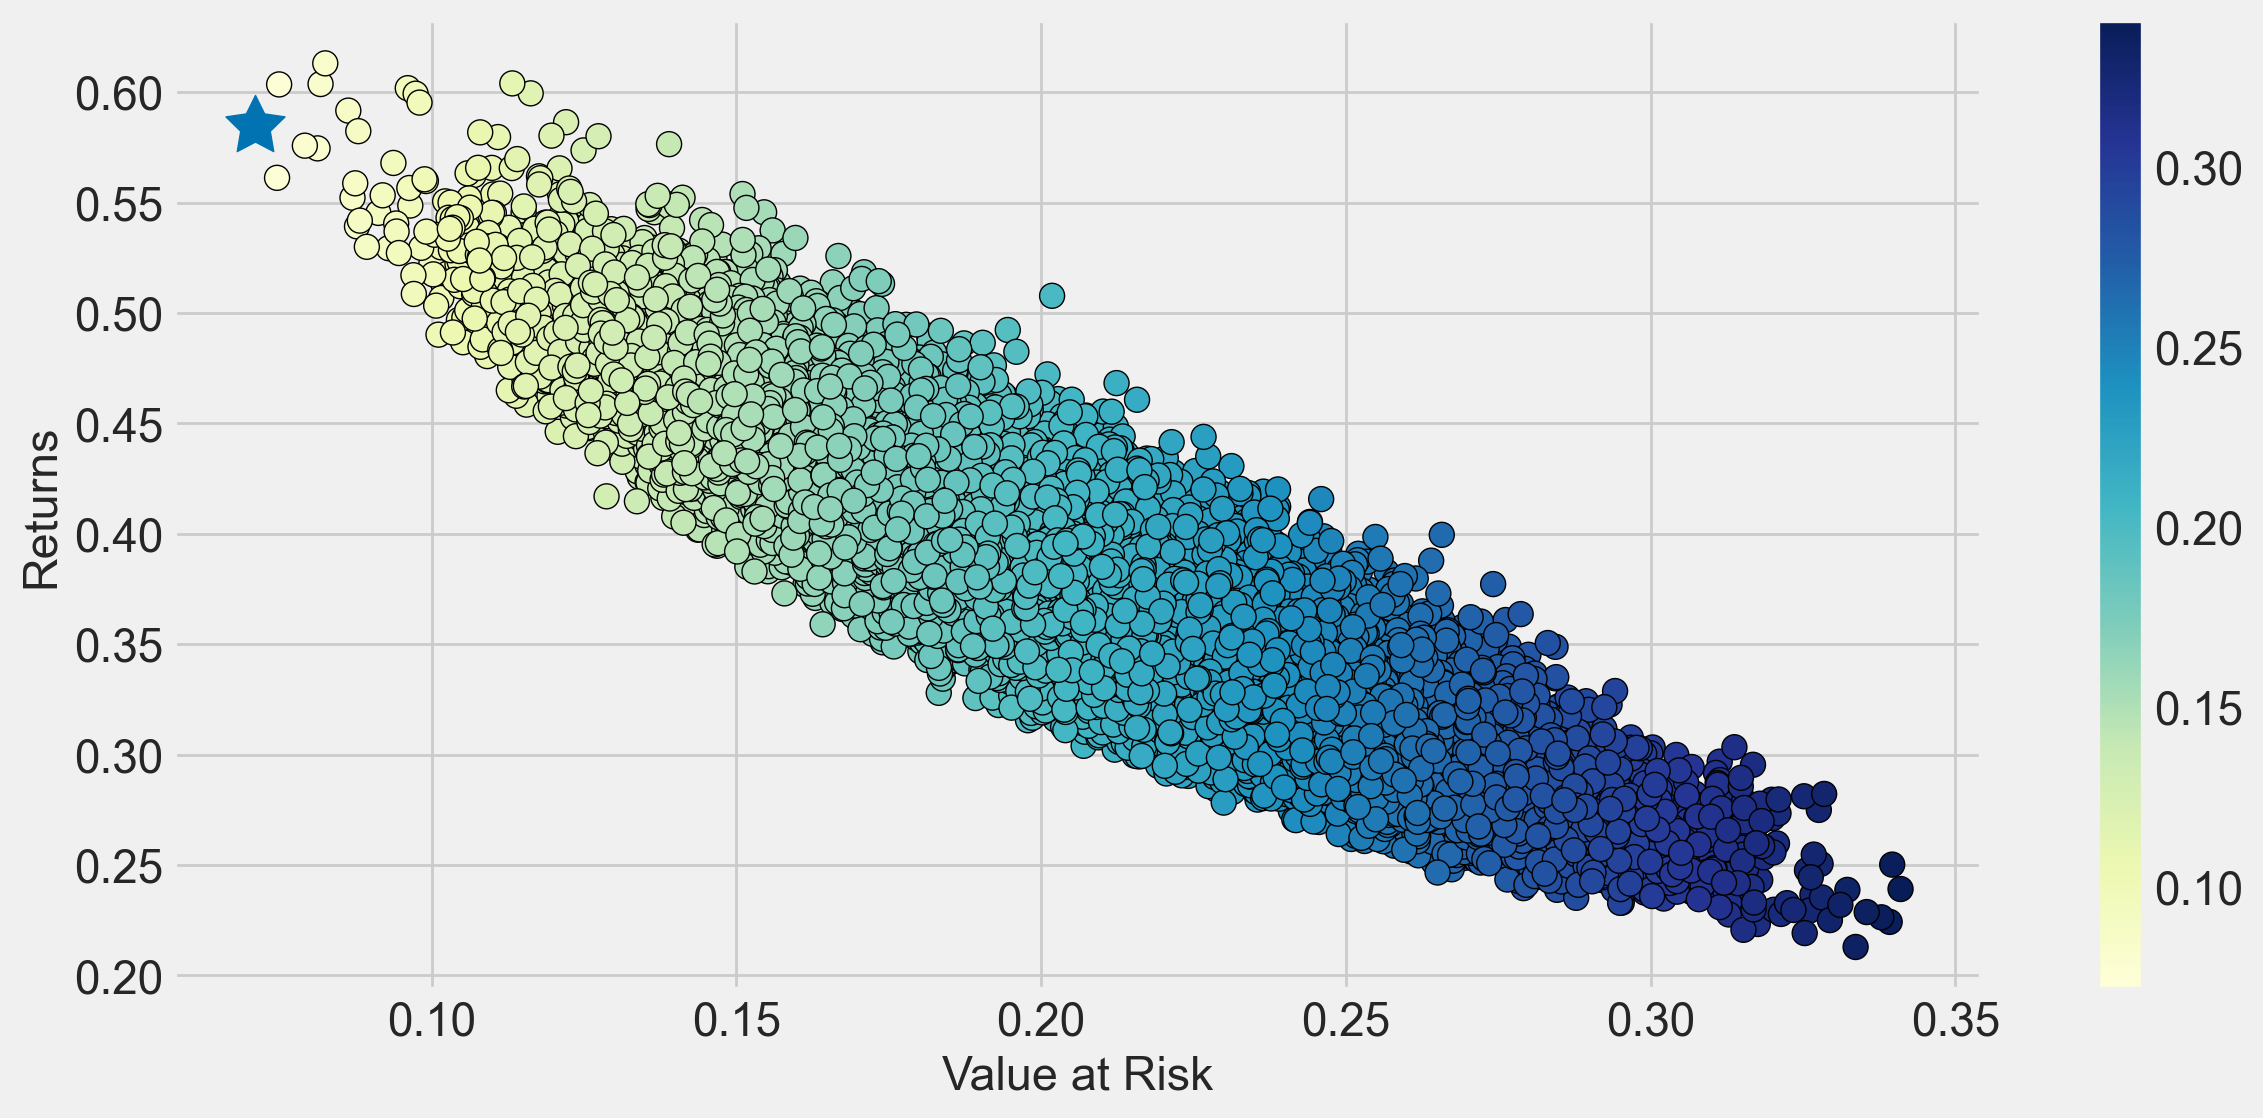

In [171]:
#locate position of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(13,6))
plt.scatter(results_frame.VaR,results_frame.ret,c=results_frame.VaR,edgecolors="black",cmap='YlGnBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()
#plot blue star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='b',s=500)
plt.show()

In [167]:
min_VaR_port.to_frame().T

ret     stdev       VaR      AAPL      ADBE       AMD      AMZN   
21056  0.58455  0.398599  0.071087  0.256608  0.011078  0.027042  0.015208  \

           GOOG      META      MSFT      NFLX      NVDA      TSLA  
21056  0.023712  0.018224  0.105019  0.054393  0.211287  0.277428

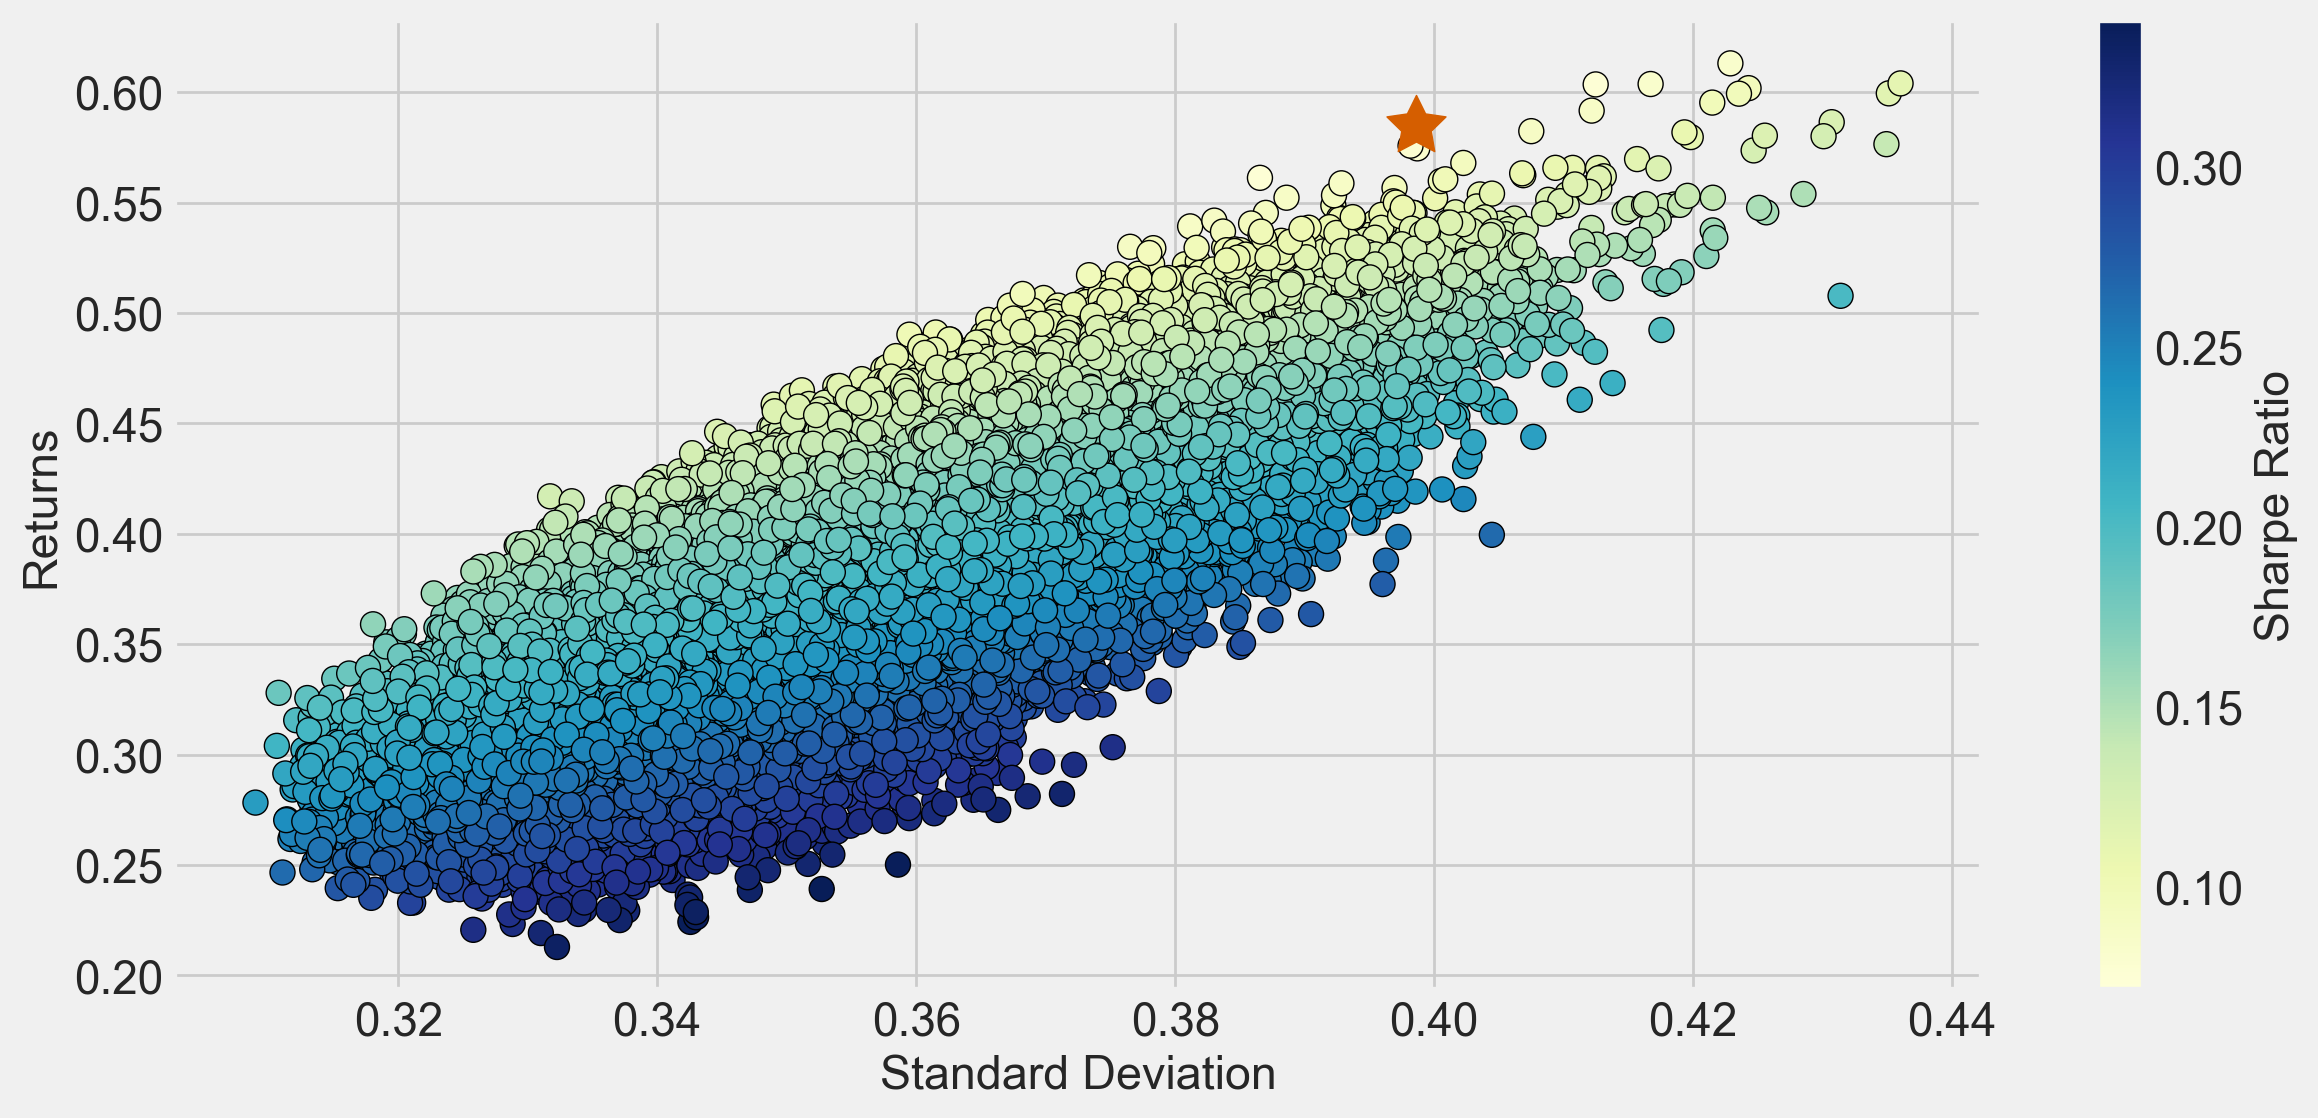

In [172]:
#locate position of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(13,6))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.VaR,edgecolors="black",cmap='YlGnBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe Ratio')
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[1],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()

In [169]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var
def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
min_port_VaR = min_VaR(mean_returns, cov, alpha, days)

In [170]:
pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=tickers).T

AAPL  ADBE  AMD  AMZN  GOOG  META  MSFT  NFLX  NVDA  TSLA
0  0.23   0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.42  0.35